In [7]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
import ROOT
from ROOT import gSystem, gInterpreter
import transporters.approximator.configuration as approximator_configuration_gen
from data.grid_configuration import CanonicalCoordinatesGridConfiguration
from data.parameters_names import ParametersNames as Parameters
import data.units as parameters_names
import transporters.transporters_factory as transporters_factory
sns.set_style("whitegrid")

In [2]:
%cd ..
%cd ..

/home/rafalmucha/Pobrane/optic/optics_generator_python
/home/rafalmucha/Pobrane/optic


In [3]:
#path_to_project = "/home/jakub/Desktop/optic_files"
path_to_project = %pwd

optic_folder_name = "2016"

serialized_approximator_file_name = "parametrization_6500GeV_0p4_185_reco.root"
approximator_name = "ip5_to_station_220_h_2_lhcb1"

In [4]:
path_to_approximator = os.path.join(path_to_project, optic_folder_name, serialized_approximator_file_name)
approximator_configuration = approximator_configuration_gen.ApproximatorConfiguration(path_to_approximator, approximator_name)
transporter = transporters_factory.get_transporter(approximator_configuration)

In [5]:
# Parameters of bunch
x_mean = 0.0
delta_x = 10e-6
theta_x_mean = 0
delta_theta_x = 10e-6
y_mean = 0.0
delta_y = 10e-6
theta_y_mean = 0.00
delta_theta_y = 10e-6
pt_mean = -0.01
delta_pt = 0.001

particles_number = 1000

In [8]:
grid_configuration = CanonicalCoordinatesGridConfiguration.from_sigma(x_mean, delta_x, particles_number,
                                                        theta_x_mean, delta_theta_x, 1,
                                                        y_mean, delta_y, 1,
                                                        theta_y_mean, delta_theta_y, 1,
                                                        pt_mean, delta_pt, 1)
particles = grid_configuration.generate_randomly()

In [9]:
output_segments = transporter(particles)

In [10]:
output_segments["start"]

In [11]:
output_segments["end"]

In [12]:
# Names of segments, like MQXA.3R5
start_segment_name = "start"
end_segment_name = "end"

if start_segment_name != "start":
    output_segments[start_segment_name].T[1] -= 1

In [13]:
output_matrix = output_segments[end_segment_name]
input_matrix = output_segments[start_segment_name]

In [16]:
def plot_histogram(x_name, y_name, x_name_prefix, y_name_prefix, 
                   x_matrix, y_matrix,
                   plot_axes, plot_x_pos, plot_y_pos):
    
    title = "Histogram " + x_name_prefix + parameters_names.alternative_version[x_name] + " and " + \
            y_name_prefix + parameters_names.alternative_version[y_name] + " parameter"
    
    # Get vectors and their properties
    
    
    vector_x = pd.Series(x_matrix.get_canonical_coordinates_of(x_name).reshape((-1,)), name=x_name_prefix + parameters_names.alternative_version[x_name])
    vector_y = pd.Series(y_matrix.get_canonical_coordinates_of(y_name).reshape((-1,)), name=y_name_prefix + parameters_names.alternative_version[y_name])
    
    bins_number = 50
    
    sns.distplot(vector_x, bins=bins_number, ax=axes[plot_x_pos][plot_y_pos], color='y').set_title(title)
    sns.distplot(vector_y, bins=bins_number, ax=axes[plot_x_pos][plot_y_pos], color='b').set_title(title)

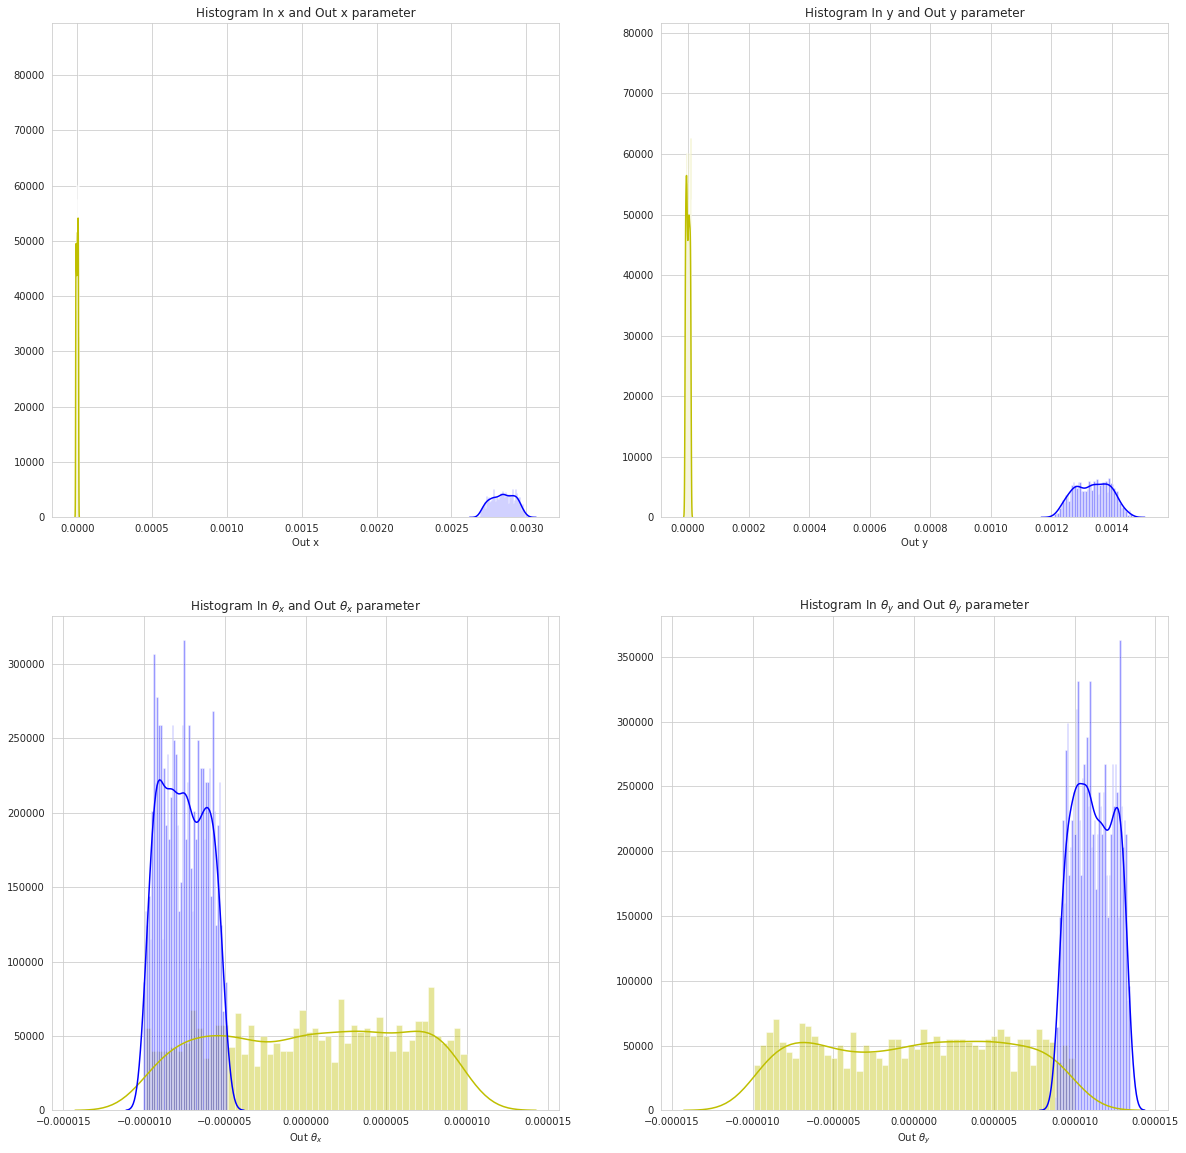

In [17]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

plot_histogram(Parameters.X, Parameters.X, "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot_histogram(Parameters.Y, Parameters.Y, "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot_histogram(Parameters.THETA_X, Parameters.THETA_X, "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot_histogram(Parameters.THETA_Y, Parameters.THETA_Y, "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)
